In [1]:
import plotting as plotting

import os
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import interpolate
import joblib

In [2]:
result_dir = 'results/'
plot_dir = 'plots/'
data_dir = 'data/'
window_size = 60000
stride = window_size
detection_method = 'idt'
bac_threshold = 0.0
data_source = 'pupilcore'
feature_sets = ['all', 'pupil', 'closure', 'onlyvel', 'onlypupil', 'onlyclosure']
feature_set_names = ['All features', 'W/O pupil features', 'W/O closure feature', 'Only eye movements', 'Only pupil features', 'Only closure features']
feature_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
my_pal = {'All features':'#1f77b4',
          'W/O pupil features':'#ff7f0e',
          'W/O closure feature':'#2ca02c',
          'Only eye movements':'#d62728',
          'Only pupil features':'#9467bd',
          'Only closure features':'#8c564b'}
group_variables = ['trial', 'subject', 'trial-time']
group_variable_names = ['closed-population (trial-split)', 'open-population', 'closed-population (time-split)']
decimals = 3
use_metric = 'aucs_instance'#'aucs_subject'
if use_metric == 'aucs_instance':
    fpr = 'fpr_instance'
    tpr = 'tpr_instance'
elif use_metric == 'aucs_subject':
    fpr = 'fpr_subject'
    tpr = 'tpr_subject'

closed-population (trial-split)
All features & 0.658 $\pm$ 0.011*\\
W/O pupil features & 0.639 $\pm$ 0.012*\\
W/O closure feature & 0.654 $\pm$ 0.005*\\
Only eye movements & 0.636 $\pm$ 0.01*\\
Only pupil features & 0.6 $\pm$ 0.0*\\
Only closure features & 0.603 $\pm$ 0.001*\\


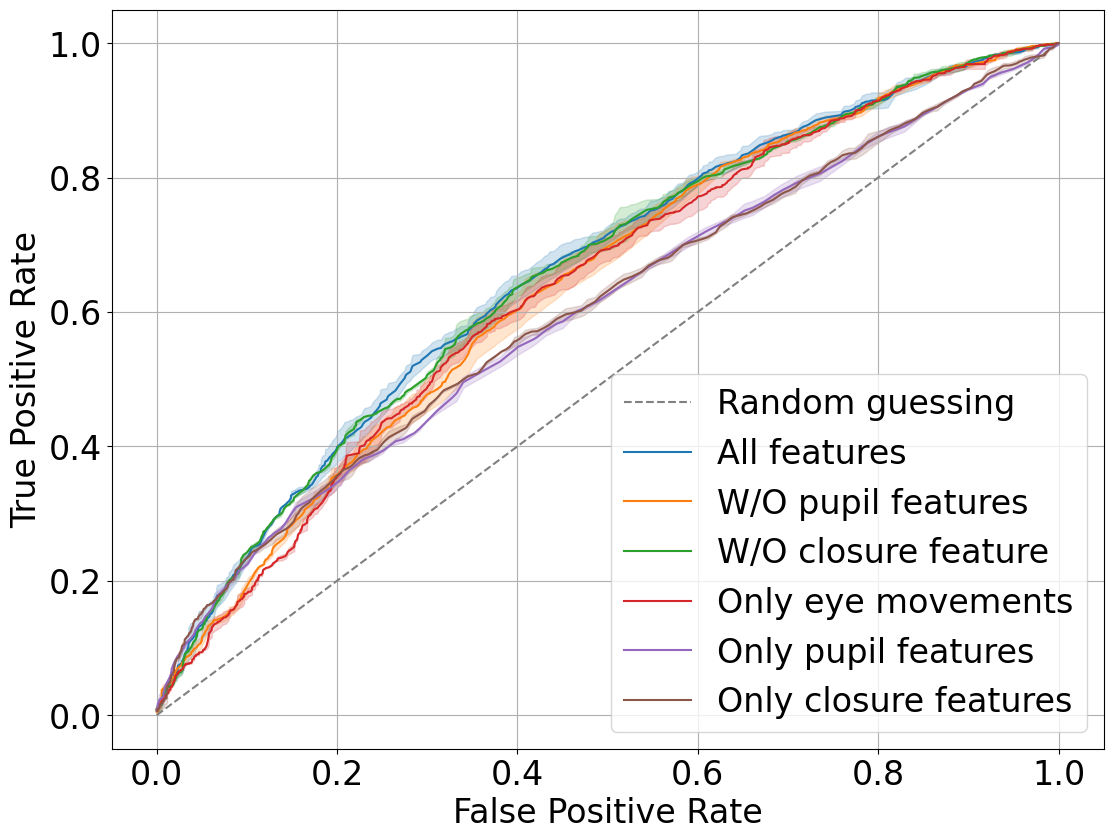

open-population
All features & 0.569 $\pm$ 0.016*\\
W/O pupil features & 0.559 $\pm$ 0.017*\\
W/O closure feature & 0.566 $\pm$ 0.013*\\
Only eye movements & 0.56 $\pm$ 0.016*\\
Only pupil features & 0.524 $\pm$ 0.031\\
Only closure features & 0.524 $\pm$ 0.028\\


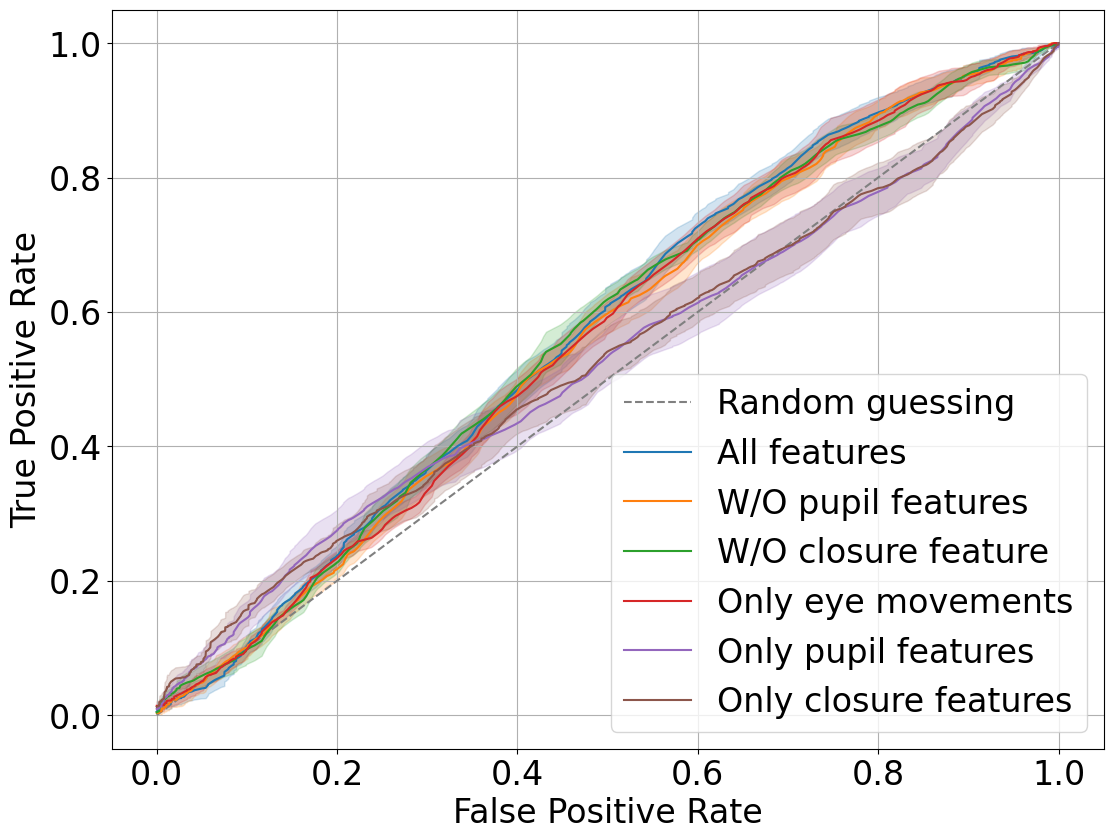

closed-population (time-split)
All features & 0.902 $\pm$ 0.01*\\
W/O pupil features & 0.882 $\pm$ 0.01*\\
W/O closure feature & 0.89 $\pm$ 0.012*\\
Only eye movements & 0.872 $\pm$ 0.015*\\
Only pupil features & 0.697 $\pm$ 0.013*\\
Only closure features & 0.699 $\pm$ 0.01*\\


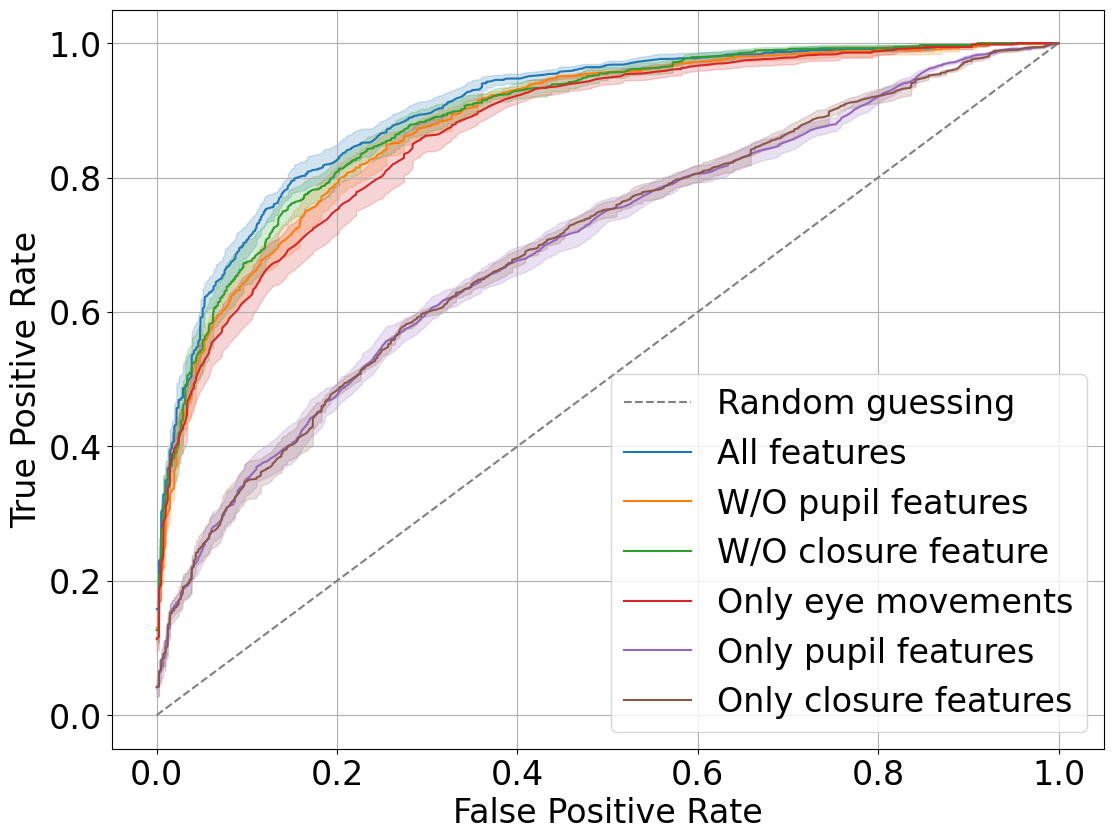

In [3]:
scale_factor = 2
for i in range(len(group_variables)):
    group_variable = group_variables[i]
    group_variable_name = group_variable_names[i]
    print(group_variable_name)
    plt.figure(figsize = [6.4*scale_factor, 4.8*scale_factor])
    for j in range(len(feature_sets)):
        cur_feature = feature_sets[j]
        cur_feature_name = feature_set_names[j]
        cur_feature_color = feature_colors[j]
        detection_string = plotting.get_detection_method_string(detection_method)
        cur_load_path = result_dir + '/' + detection_string + '_' + data_source + '_' +\
                        'window_' + str(window_size) + '_' +\
                        'stride_' + str(stride) + '_' +\
                        'bac_' + str(bac_threshold) + '_' +\
                        'splitting_' + str(group_variable) + '_' +\
                        'feature_' + str(cur_feature) + '_rf' + '_save_scores'
        joblib_path = cur_load_path + '.joblib'
        csv_path = cur_load_path + '.csv'
        cur_data = joblib.load(joblib_path)
        cur_df = pl.read_csv(csv_path)
        if j == 0:
            plot_random = True
        else:
            plot_random = False
        cur_aucs = np.array(cur_df[use_metric])
        better_random_pvalue = ttest_1samp(a=cur_aucs,popmean=0.5,alternative = 'greater').pvalue
        if better_random_pvalue < 0.05:
            cur_p_value_add_str = '*'
        else:
            cur_p_value_add_str = ''
        table_str = cur_feature_name + ' & ' + str(np.round(np.mean(cur_aucs), decimals)) + ' $\\pm$ ' +\
                        str(np.round(np.std(cur_aucs) / np.sqrt(len(cur_aucs)), decimals)) + cur_p_value_add_str + '\\\\'
        print(table_str)
        plotting.avg_tpr_fpr_curve(cur_data[fpr], cur_data[tpr], cur_feature_name, plot_random=plot_random,
                          plot_statistics=False, fontsize = 24, loc='lower right', color=cur_feature_color)
    plt.savefig(plot_dir + group_variable_name + '_' + str(data_source) + '_auc.pdf', dpi=300)
    plt.show()